### TensorBoard
TensorBoard 提供机器学习实验所需的可视化功能和工具：

跟踪和可视化损失及准确率等指标

可视化模型图（操作和层）

查看权重、偏差或其他张量随时间变化的直方图

将嵌入投射到较低的维度空间

显示图片、文字和音频数据

剖析 TensorFlow 程序

In [1]:
# GPU support
# MNIST
# DataLoader, Transformation
# Multilayer Neural Net, activation function
# Loss and Optimizer
# Training Loop (batch training)
# model evaluation

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import sys
import torch.nn.functional as F

In [2]:
writer = SummaryWriter("/Users/lucas/Documents/runs/mnist3")

In [3]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# hyper parameters
input_size = 784 # 28x28
hidden_size = 100
num_classes = 10
num_epochs = 1
batch_size = 100
learning_rate = 0.01

torch.Size([100, 1, 28, 28]) torch.Size([100])


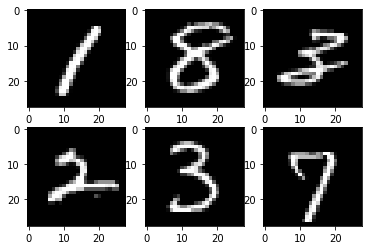

In [5]:
# MNIST
## download=True make sure it would be downloaded if it's not available
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# DataLoader, Transformation
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)
# torch.Size([100, 1, 28, 28]) torch.Size([100])
# [batch_size, num_channels, image_row, image_col] [batch_size]

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray') # [0] 表示 channel， cmap=color map

# plt.show()
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)
# writer.close()
# sys.exit()

In [6]:
# Multilayer Neural Net, activation function
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, num_classes)
            
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        # 这里因为要使用 Cross Entropy，所以不用添加 Softmax
        return out
        
model = NeuralNet(input_size, hidden_size, num_classes)

In [7]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
writer.add_graph(model, samples.reshape(-1, 28*28))
# writer.close()
# sys.exit()

In [9]:
# training loop
n_total_steps = len(train_loader)

running_loss = 0.0
running_correct = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # now we have to reshape images first
        # origianl shape [100, 1, 28, 28]
        # batch_size=100, num_channel=1, 28, 28
        # num_samples=100, num_features=784=28x28
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # update parameters
        
        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        running_correct += (predictions == labels).sum().item()
        if (i+1) % 10 == 0:
#             print(f"epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}")
            writer.add_scalar('training loss', running_loss/10, epoch*n_total_steps+i)
            writer.add_scalar('accuracy', running_correct/10, epoch*n_total_steps+i)
            running_loss = 0.0
            running_correct = 0
# writer.close()
            

In [10]:
# model evaluation
labels1 = []
preds = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # value, index
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        
        class_predictions = [F.softmax(output, dim=0) for output in outputs]
        preds.append(class_predictions)
        labels1.append(predictions)
    
    preds = torch.cat([torch.stack(batch) for batch in preds])
    labels1 = torch.cat(labels1)
        
acc = 100.0 * n_correct / n_samples
print(f"Accuracy = {acc}")

Accuracy = 95.96


In [11]:
classes = range(10)
for i in classes:
    labels_i = labels1 == i
    preds_i = preds[:, 1]
    writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
    writer.close()